In [57]:
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA, FastICA,  IncrementalPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import cluster
from glob import glob
import random
import cv2
from clustimage import Clustimage
from keras.preprocessing.image import img_to_array, load_img 
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Model

In [242]:
images=random.sample(glob('crop_part1/*'),500)
img = load_img(images[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

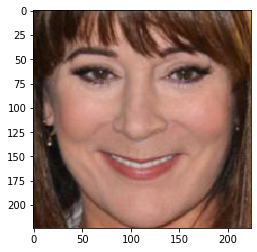

In [243]:
plt.imshow(img)

In [244]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [245]:
def get_features(file, model):
    img = load_img(file, target_size=(224,224))
    img = np.array(img) 
    reshaped_img = img.reshape(1,224,224,3) 
    imgx = preprocess_input(reshaped_img)
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [246]:
data = {}
for image in images:
    data[image] = get_features(image, model)

In [247]:
keys = np.array(list(data.keys()))
feats = np.array(list(data.values()))
feats = feats.reshape(-1,4096)

In [281]:
pca = PCA(n_components=35)
transformed_images=pca.fit_transform(feats)

In [282]:
print(f"Components before PCA: {len(feats[0])}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 35


In [283]:
#so the first 100 components explains 90 % of the variance
np.cumsum(pca.explained_variance_ratio_)

array([0.21352139, 0.28797442, 0.33487323, 0.3740597 , 0.4082985 ,
       0.43695092, 0.46163923, 0.48401013, 0.505184  , 0.5245718 ,
       0.5410726 , 0.5569012 , 0.5719478 , 0.5849576 , 0.596482  ,
       0.6073436 , 0.61748004, 0.627084  , 0.6363449 , 0.6451033 ,
       0.6535063 , 0.6614268 , 0.669108  , 0.67651117, 0.6834804 ,
       0.6903599 , 0.69688725, 0.7032302 , 0.70882875, 0.7143518 ,
       0.71965486, 0.7245332 , 0.7293511 , 0.73402107, 0.7385319 ],
      dtype=float32)

In [284]:
ica = FastICA(n_components=20)
transformed_images_ica = ica.fit_transform(transformed_images)

In [292]:
kmeans = KMeans(n_clusters=10 ,n_jobs=6, random_state=42)
kmeans.fit(transformed_images_ica)

KMeans(n_clusters=10, n_jobs=6)

In [293]:
groups = {}
for file, cluster in zip(images,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

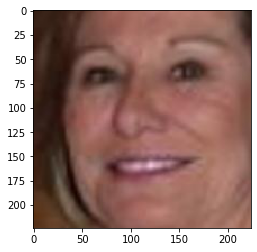

In [294]:
count=0
temp=[]
clusterNR = 3
for i in groups[clusterNR]:
    temp.append(load_img((glob(str(groups[clusterNR][count])))[0],target_size=(224,224)))
    count +=1
plt.imshow(temp[4])

In [295]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    if len(files) > 50:
        files = files[:50]
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Cluster{cluster}')

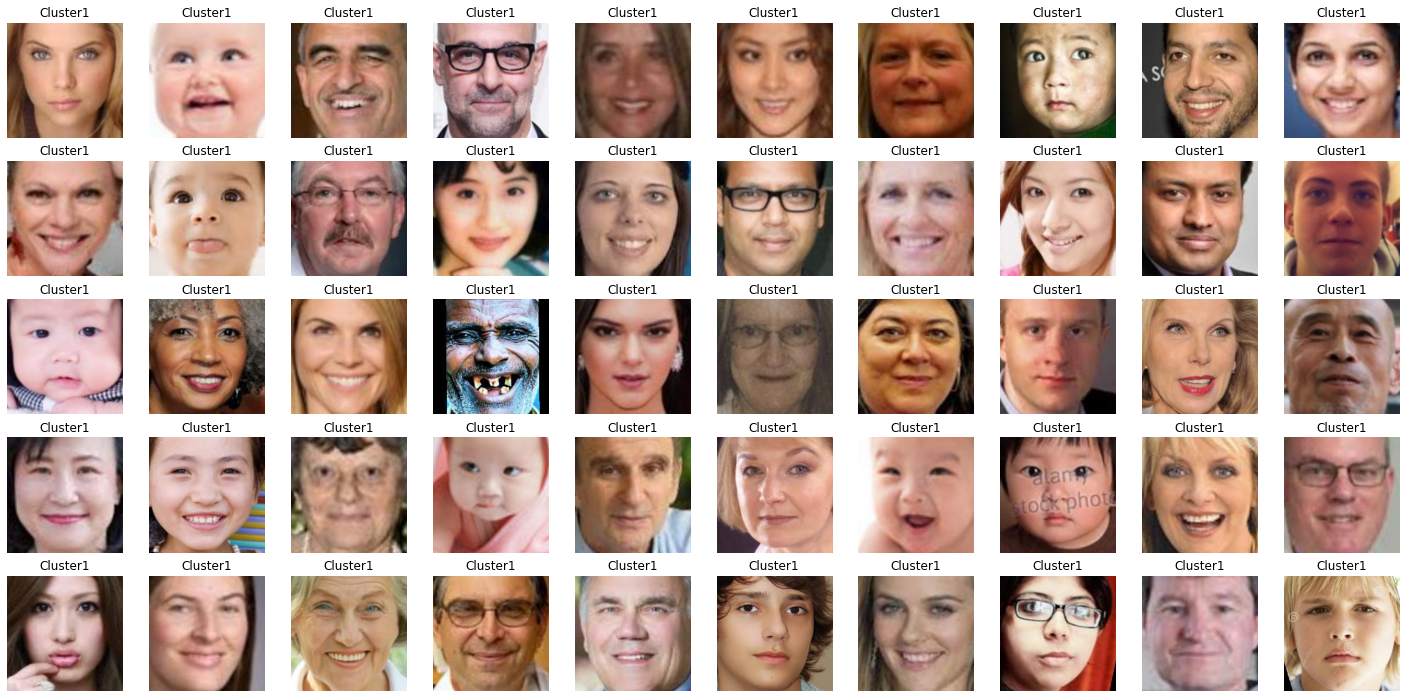

In [296]:
view_cluster(1)

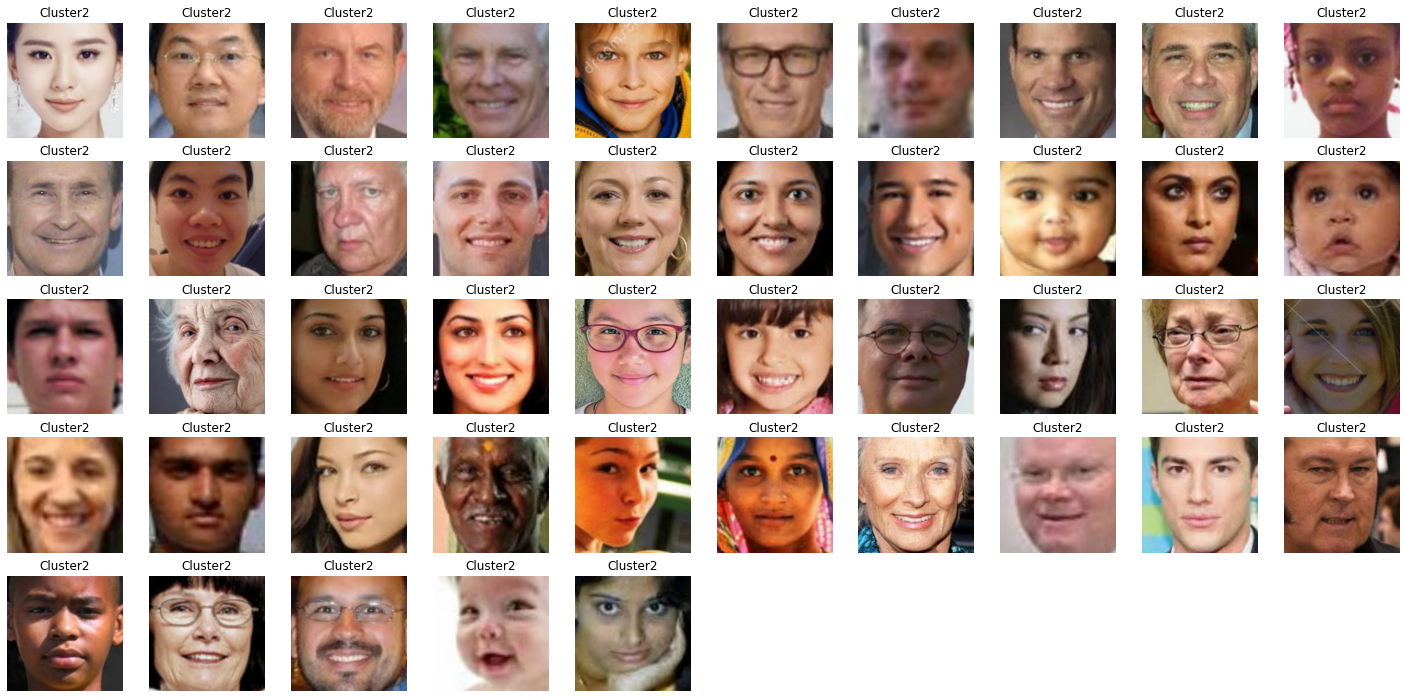

In [290]:
view_cluster(2)

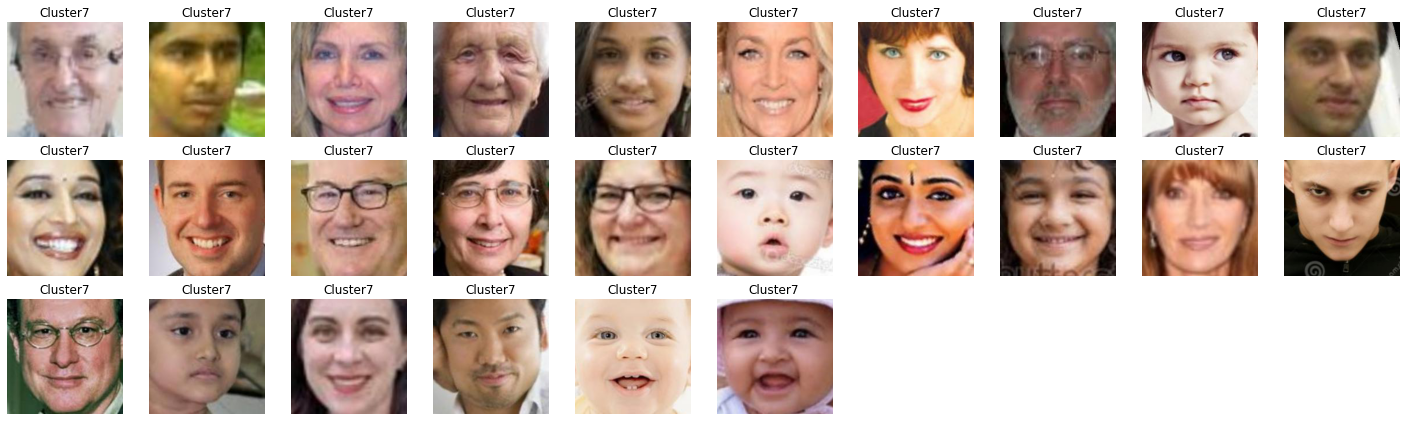

In [291]:
view_cluster(7)

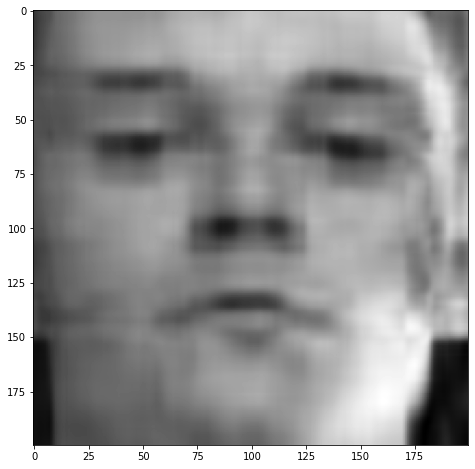

In [242]:
pca = PCA(n_components=4)
image_recon = pca.inverse_transform(pca.fit_transform(X[0]))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)

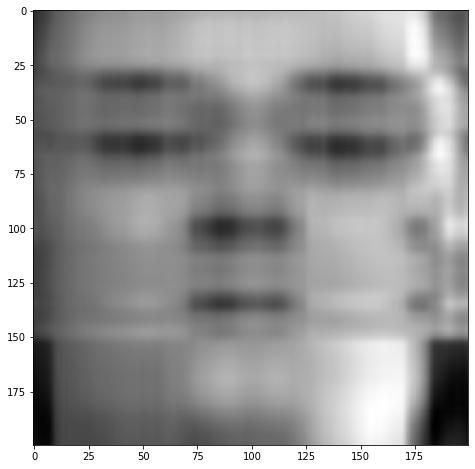

In [234]:
ica = FastICA(n_components=3)
image_recon_ica = ica.inverse_transform(ica.fit_transform(image_recon))
 
# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon_ica,cmap = plt.cm.gray)